# 6_Modeling & Parameter Tuning

In [1]:
%matplotlib inline
import os
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
train = pd.read_csv("C:/Users/kimch/Desktop/229255_bus_riders_at_rush_hour_data/preprocessed_train.csv")
train = train.drop(columns=["Unnamed: 0", "Unnamed: 0.1"])
train.set_index("id", inplace=True)
train["date"] = pd.to_datetime(train.date, format= "%Y-%m-%d")

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415423 entries, 0 to 415422
Data columns (total 31 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   date           415423 non-null  datetime64[ns]
 1   bus_route_id   415423 non-null  int64         
 2   station_code   415423 non-null  int64         
 3   station_name   415423 non-null  object        
 4   latitude       415423 non-null  float64       
 5   longitude      415423 non-null  float64       
 6   6~7_ride       415423 non-null  float64       
 7   7~8_ride       415423 non-null  float64       
 8   8~9_ride       415423 non-null  float64       
 9   9~10_ride      415423 non-null  float64       
 10  10~11_ride     415423 non-null  float64       
 11  11~12_ride     415423 non-null  float64       
 12  6~7_takeoff    415423 non-null  float64       
 13  7~8_takeoff    415423 non-null  float64       
 14  8~9_takeoff    415423 non-null  float64       
 15  

## Train -> Train, Valid, Test

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
# drop_first=True해서 in_out_시내, rain_0 제외하고 train_X column에 넣음
X = train[['bus_route_id','latitude','longitude', '6~7_ride','7~8_ride', '8~9_ride','9~10_ride','10~11_ride','11~12_ride','6~7_takeoff',
           '7~8_takeoff','8~9_takeoff','9~10_takeoff','10~11_takeoff','11~12_takeoff','region_e', 'region_n', 'region_o', 'region_s', 
           'region_w', 'in_out_시외', 'rain_1', 'rain_2', 'rain_3']]

y = train[["18~20_ride"]]

# train:valid:test = 6:2:2
train_X, resid_X, train_y, resid_y = train_test_split(X, y, test_size = 0.4, shuffle=True, random_state= 17)
valid_X, test_X, valid_y, test_y = train_test_split(resid_X, resid_y, test_size = 0.5, shuffle=True)

In [7]:
train_X.shape

(249253, 24)

In [8]:
valid_X.shape

(83085, 24)

In [9]:
test_X.shape

(83085, 24)

## Ridge + BayesianRidge  
references : https://woolulu.tistory.com/7

L2 normalization -> Ridge, L1 normalization -> Lasso  
  
Ridge Regression 최소제곱법과 매우 유사,   
but **각 계수의 제곱을 더한 값**을 식에 포함, *(Lasso는 각 계수의 절댓값의 합이 포함),*     
계수의 크기도 함께 최소화하도록 함  
(Ridge는 coefficient를 0에 가깝게 만들지만, Lasso는 coefficient를 0으로 만든다)
  
람다값을 조절 -> over fitting 방지  
overfitting 되면 회귀계수의 값이 매우 크게 나타남
-> variance 큰 상황 막기 위해, 계수가 크면 페널티를 주는 수식을 추가
  
람다값이 크면 계수를 많이 줄이는데 집중, 작으면 일반적인 선형회귀모형  
-> 람다값 클수록 계수의 크기가 shrink됨

In [10]:
from sklearn.linear_model import LinearRegression,Ridge, BayesianRidge
from sklearn.metrics import mean_squared_error
from dmba import regressionSummary

In [11]:
# Ridge
# alpha 파라미터로 model을 얼마나 단순화할지 결정 
# alpha : default=1, 값이 높을수록 regularization을 강화하여 계수를 0에 가깝게 함 (0 < alpha < inf)

### Ridge(normalize = False)

In [12]:
# alpha 값에 따른 정확도 비교
train_rmse = []
valid_rmse = []
test_rmse = []

alpha_set = [0.1, 1, 5, 10]

for i in alpha_set:
    ridge = Ridge(alpha=i, normalize=False)
    ridge.fit(train_X, train_y)
    
    train = round(mean_squared_error(train_y, ridge.predict(train_X), squared=False), 4)
    valid = round(mean_squared_error(valid_y, ridge.predict(valid_X), squared=False), 4)
    test = round(mean_squared_error(test_y, ridge.predict(test_X), squared=False), 4)
    
    train_rmse.append(train)
    valid_rmse.append(valid)
    test_rmse.append(test)

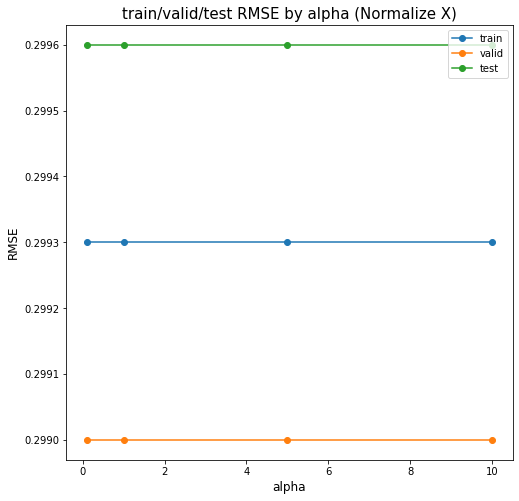

In [13]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()

ax.plot(alpha_set, train_rmse, marker='o', label="train")
ax.plot(alpha_set, valid_rmse, marker='o', label='valid')
ax.plot(alpha_set, test_rmse, marker='o', label='test')

ax.legend()

plt.title("train/valid/test RMSE by alpha (Normalize X)", fontsize=15)
plt.xlabel("alpha", fontsize=12)
plt.ylabel("RMSE", fontsize=12)

plt.show()

In [14]:
print("train :", train_rmse)
print("valid :", valid_rmse)
print("test :", test_rmse)

train : [0.2993, 0.2993, 0.2993, 0.2993]
valid : [0.299, 0.299, 0.299, 0.299]
test : [0.2996, 0.2996, 0.2996, 0.2996]


왜인지는 모르겠지만 alpha값에 차이가 없이 rmse 스코어 같음

### Ridge(normalize=True)

In [15]:
# alpha 값에 따른 정확도 비교
train_rmse = []
valid_rmse = []
test_rmse = []

alpha_set = [0.1, 1, 5, 10]

for i in alpha_set:
    ridge = Ridge(alpha=i, normalize=True)
    ridge.fit(train_X, train_y)
    
    train = round(mean_squared_error(train_y, ridge.predict(train_X), squared=False), 4)
    valid = round(mean_squared_error(valid_y, ridge.predict(valid_X), squared=False), 4)
    test = round(mean_squared_error(test_y, ridge.predict(test_X), squared=False), 4)
    
    train_rmse.append(train)
    valid_rmse.append(valid)
    test_rmse.append(test)

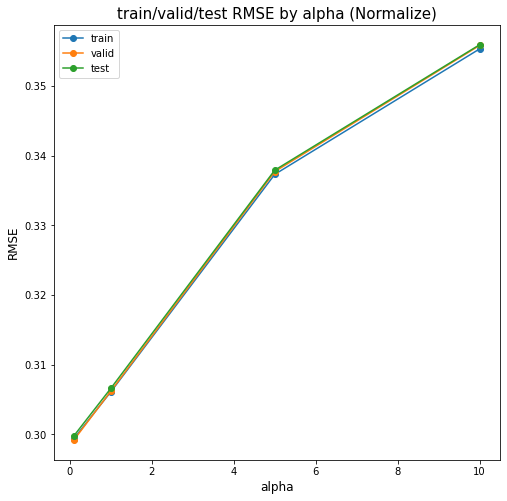

In [16]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()

ax.plot(alpha_set, train_rmse, marker='o', label="train")
ax.plot(alpha_set, valid_rmse, marker='o', label='valid')
ax.plot(alpha_set, test_rmse, marker='o', label='test')

ax.legend()

plt.title("train/valid/test RMSE by alpha (Normalize)", fontsize=15)
plt.xlabel("alpha", fontsize=12)
plt.ylabel("RMSE", fontsize=12)

plt.show()

In [17]:
# alpha 값이 커질수록 (규제 강화될수록), 정확도 떨어짐 (RMSE 커짐)
print("train :", train_rmse)
print("valid :", valid_rmse)
print("test :", test_rmse)

train : [0.2994, 0.3061, 0.3373, 0.3553]
valid : [0.2992, 0.3062, 0.3377, 0.3558]
test : [0.2998, 0.3066, 0.3379, 0.3559]


### BayesianRidge

In [18]:
# BayesianRidge
bayesianRidge = BayesianRidge(normalize=True)  
# normalize(0~1 사이 값으로 만드는 것) BayesianRidge는 normalize T/F에 따라 rmse 차이 없음
bayesianRidge.fit(train_X, train_y)

BayesianRidge(normalize=True)

In [19]:
## train
regressionSummary(train_y, bayesianRidge.predict(train_X))


Regression statistics

               Mean Error (ME) : 0.0000
Root Mean Squared Error (RMSE) : 0.2993
     Mean Absolute Error (MAE) : 0.2168


In [20]:
## valid
regressionSummary(valid_y, bayesianRidge.predict(valid_X))


Regression statistics

               Mean Error (ME) : 0.0008
Root Mean Squared Error (RMSE) : 0.2990
     Mean Absolute Error (MAE) : 0.2166


In [21]:
## test
regressionSummary(test_y, bayesianRidge.predict(test_X))


Regression statistics

               Mean Error (ME) : 0.0008
Root Mean Squared Error (RMSE) : 0.2996
     Mean Absolute Error (MAE) : 0.2164


In [22]:
## Bayesian Ridge : 찾아봤는데 이해가 안됨 ㅜ
print("Bayesian Ridge chosen regularization :", bayesianRidge.lambda_ / bayesianRidge.alpha_)

Bayesian Ridge chosen regularization : 0.00037945893677466196


## LGBM  
references : https://nicola-ml.tistory.com/51

LightGBM (Light Gradient Bossting Machine) : 틀린부분에 가중치를 더하면서 진행하는 알고리즘
- Tree 기반 알고리즘, but 수평적으로 확장하는 다른 Tree 기반 알고리즘에 비해 수직적을 확장
- LGBM : leaf-wise (다른 알고리즘은 level-wise), light = 속도가 빠름
- 장점 : 속도가 빠르다, 큰 사이즈의 데이터를 다룰 수 있다, 적은 메모리 사용, 정확도 높다, gpu를 활용할 수 있음
- 단점 : 다른 tree 알고리즘보다 과적합 위험 큼, 따라서 데이터의 양이 적을 경우 사용 자제, 데이터 10,000개 이상일 때 추천

**LGBM 파라미터**  
1. max_depth : tree의 최대 깊이, 너무 깊으면 과적합 위험 有
2. min_child_samples : leaf가 가지고 있는 최소한의 레코드 수, 과적합 방지, default=20  
3. feature_fraction : tree 만들때 매 반복에서 파라미터 중에 feature_fraction만큼을 랜덤하게 선택 (ex: 0.8이면 파라미터의 80%만 랜덤하게 선택)   
4. bagging_fraction : 매 반복에서 bagging_fraction 만큼의 데이터를 선택, 트레이닝 속도 높이고 과적합 방지  
5. early_stopping_round : 파라미터의 분석 속도를 높임, valid 데이터의 정확도가early_stopping_round에서 향상되지 않았다면 학습 중단, 지나친 반복 안하도록 도움  
6. lambda : 정규화(regularization), 0 < labmda < 1
7. min_gain_to_split : split하기 위한 최소한의 gain, split하는 것이 유용할때까지만 split
8. task : 데이터에 대해서 수행하고자하는 임무를 구체화, train or **predict**
9. application : **regression**, binary, multiclass
10. boosting : 실행하고자하는 알고리즘 타입 
- gbdt : default, traditional gradient boosting decision tree
- rf : random forest
- **dart : dropouts meet Multiple Additive Regression Trees**
- goss : Gradient-based One-side Samplig
11. num_boost_round : boosting iteration 수 (반복 횟수), 일반적으로 100 이상 (= n_estimators)
12. learning_rate : 학습률, 0.1, 0.001, 0.003
13. num_leaves : 전체 tree의 leaves 수, default = 31
14. metric : 모델의 손실, mae, mse, **rmse**, binary_logloss, multi_logloss

### Hyperparameter 튜닝  
- **GridSearchCV** :   
완전 탐색 (모든 조합에 대해 교차검증), 파라미터 많으면 매우 많은 시간 소요
- **RandomizedSearchCV** :  
모든 조합을 다 시도하지 않고, 각 반복마다 임의의 값만 대입해 지정한 횟수만큼 평가함, 정확도 떨어짐
- **Bayesian Optimization** :   
GridSearch, RandomizedSearch에 비해 효율적으로 최적값을 찾아낸다는 장점, 파라미터 범위 정해주면 최적 파라미터 값 도출

In [23]:
import lightgbm as lgb

### BayesianOptimization  
**boosting=dart**

In [24]:
from bayes_opt import BayesianOptimization

In [25]:
# 탐색 대상 함수
def lgbm_cv(max_depth, n_estimators, min_child_samples, num_leaves, min_split_gain, feature_fraction, bagging_fraction, learning_rate, early_stopping_rounds):
    # 모델 정의
    model= lgb.LGBMRegressor(max_depth = int(max_depth),
                             n_estimators = int(n_estimators),
                             min_child_samples = int(min_child_samples),
                             num_leaves = int(num_leaves),
                             min_split_gain = min_split_gain,
                             feature_fraction = feature_fraction,
                             bagging_fraction = bagging_fraction, 
                             learning_rate = learning_rate,
                             early_stopping_rounds = int(early_stopping_rounds),
                             boosting = "dart",
                             metric = "rmse",
                             task = "predict",
                             application = "regression",
                             eval_set = (valid_X, valid_y))
    
    # 모델 훈련
    model.fit(train_X, train_y)
    
    # 예측값
    pre_y = model.predict(test_X)
    
    # metric 계산
    rmse = mean_squared_error(test_y, ridge.predict(test_X), squared=False)
    
    return rmse

In [26]:
pbounds = {"max_depth": (10,20),
           "n_estimators": (50, 300),
           "min_child_samples": (10, 30),
           "num_leaves": (20,40),
           "min_split_gain": (0, 0.5),
           "feature_fraction": (0.5, 1),
           "bagging_fraction": (0.5, 1),
           "learning_rate": (0, 0.1),
           "early_stopping_rounds": (10, 300)}

# Bayesian optimization 객체 생성
bo = BayesianOptimization(f = lgbm_cv, pbounds=pbounds, verbose=2, random_state=11)

# maximize 메소드를 이용해 최대화 과정 수행
bo.maximize(init_points=2, n_iter=15, acq="ei", xi=0.01)

# 찾은 파라미터값 확인
print(bo.max)

|   iter    |  target   | baggin... | early_... | featur... | learni... | max_depth | min_ch... | min_sp... | n_esti... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] 0.000000 is set=, 0.000000= will be ignored. Current value: 0.000000=
[LightGBM] [Warning] 0.000000 is set=, 0.000000= will be ignored. Current value: 0.000000=
[LightGBM] [Warning] 0.000000 is set=, 0.000000= will be ignored. Current value: 0.000000=
[LightGBM] [Warning] 0.000000 is set=, 0.000000= will be ignored. Current value: 0.000000=
[LightGBM] [Warning] 0.000000 is set=, 0.000000= will be ignored. Current value: 0.000000=
[LightGBM] [Warning] 0.526589 is set=, 0.526589= will be ignored. Current value: 0.526589=
[LightGBM] [Warning] 0.526589 is set=, 0.526589= will be ignored. Current value: 0.526589=
[LightGBM] [Warning] 0.000000 is set=, 0.000000= will be ignored. Current value: 0.000000=
[Lig

In [28]:
best_lgbm = lgb.LGBMRegressor(bagging_fraction=0.6,
                              early_stopping_rounds=16,
                              feature_fraction=0.73,
                              learning_rate = 0.07,
                              max_depth = 14,
                              min_child_samples = 20,
                              min_split_gain = 0.0064, 
                              n_estimators = 172,
                              num_leaves = 39,
                              boosting = "dart",
                              metric = "rmse",
                              task = "predict",
                              application = "regression",
                              eval_set = (valid_X, valid_y))

best_lgbm.fit(train_X, train_y)

[LightGBM] [Warning] 0.000000 is set=, 0.000000= will be ignored. Current value: 0.000000=
[LightGBM] [Warning] 0.000000 is set=, 0.000000= will be ignored. Current value: 0.000000=
[LightGBM] [Warning] 0.000000 is set=, 0.000000= will be ignored. Current value: 0.000000=
[LightGBM] [Warning] 0.000000 is set=, 0.000000= will be ignored. Current value: 0.000000=
[LightGBM] [Warning] 0.000000 is set=, 0.000000= will be ignored. Current value: 0.000000=
[LightGBM] [Warning] 0.526589 is set=, 0.526589= will be ignored. Current value: 0.526589=
[LightGBM] [Warning] 0.526589 is set=, 0.526589= will be ignored. Current value: 0.526589=
[LightGBM] [Warning] 0.000000 is set=, 0.000000= will be ignored. Current value: 0.000000=
[LightGBM] [Warning] 0.000000 is set=, 0.000000= will be ignored. Current value: 0.000000=
[LightGBM] [Warning] 0.526589 is set=, 0.526589= will be ignored. Current value: 0.526589=
[LightGBM] [Warning] 0.000000 is set=, 0.000000= will be ignored. Current value: 0.000000=

LGBMRegressor(application='regression', bagging_fraction=0.6, boosting='dart',
              early_stopping_rounds=16,
              eval_set=(        bus_route_id  latitude  longitude  6~7_ride  7~8_ride  8~9_ride  \
id                                                                        
58799       23030000  33.51464  126.55624  0.000000  0.000000  0.526589   
207599      28700000  33.50495  126.50765  0.000000  0.000000  0.000000   
36305       28840000  33.50419  126.50338  0.000000  0.526589  0.526589   
302221      27320000  33.325...
326921       0       0  
220303       0       0  

[83085 rows x 24 columns],
                                18~20_ride
id                
58799     0.526589
207599    0.000000
36305     0.000000
302221    0.000000
400345    0.000000
...            ...
117497    0.000000
317564    0.000000
40136     0.000000
326921    0.000000
220303    0.000000

[83085 rows x 1 columns]),
              feature_fraction=0.73, learning_rate=0.07, max_depth=14,
              metric='rmse', min_split_gain=0.0064, n_estimators=172,
              num_leaves=39, task='predict')

In [29]:
regressionSummary(train_y, best_lgbm.predict(train_X))


Regression statistics

               Mean Error (ME) : 0.0293
Root Mean Squared Error (RMSE) : 0.2889
     Mean Absolute Error (MAE) : 0.2013


In [30]:
regressionSummary(valid_y, best_lgbm.predict(valid_X))


Regression statistics

               Mean Error (ME) : 0.0302
Root Mean Squared Error (RMSE) : 0.2908
     Mean Absolute Error (MAE) : 0.2025


In [31]:
regressionSummary(test_y, best_lgbm.predict(test_X))


Regression statistics

               Mean Error (ME) : 0.0300
Root Mean Squared Error (RMSE) : 0.2911
     Mean Absolute Error (MAE) : 0.2022


bayesianRidge보다 아주 조금 더 성능 좋음

**다음 시간**  
1. 파라미터 튜닝 보완 (+ 모델 추가 ?)
2. 앙상블 모델